In [1]:
import astropy
from astropy.io import fits
import numpy as np
from numpy import *
%matplotlib inline
import matplotlib.pyplot as plt
from  matplotlib.pyplot import *



In [2]:
gdn_cat = np.loadtxt('/Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.3.cat')
gdn_cat_v41 = np.loadtxt('/Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat')
gdn_nzpcat = np.loadtxt('/Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.3.nzpcat')
gdn_plus = np.loadtxt('/Users/rsimons/Desktop/clear/Catalogs/GoodsS_plus.cat')



In [7]:
colnames = 'id x y ra dec faper_F160W eaper_F160W faper_F140W eaper_F140W f_F160W e_F160W w_F160W f_U50 e_U50 w_U50 f_U38 e_U38 w_U38 f_U e_U w_U f_F435W e_F435W w_F435W f_B e_B w_B f_V e_V w_V f_F606Wcand e_F606Wcand w_F606Wcand f_F606W e_F606W w_F606W f_R e_R w_R f_Rc e_Rc w_Rc f_F775W e_F775W w_F775W f_I e_I w_I f_F814Wcand e_F814Wcand w_F814Wcand f_F850LP e_F850LP w_F850LP f_F850LPcand e_F850LPcand w_F850LPcand f_F098M e_F098M w_F098M f_F105W e_F105W w_F105W f_F125W e_F125W w_F125W f_J e_J w_J f_tenisJ e_tenisJ w_tenisJ f_F140W e_F140W w_F140W f_H e_H w_H f_tenisK e_tenisK w_tenisK f_Ks e_Ks w_Ks f_IRAC1 e_IRAC1 w_IRAC1 f_IRAC2 e_IRAC2 w_IRAC2 f_IRAC3 e_IRAC3 w_IRAC3 f_IRAC4 e_IRAC4 w_IRAC4 f_IA427 e_IA427 f_IA445 e_IA445 f_IA464 e_IA464 f_IA484 e_IA484 f_IA505 e_IA505 f_IA527 e_IA527 f_IA550 e_IA550 f_IA574 e_IA574 f_IA598 e_IA598 f_IA624 e_IA624 f_IA651 e_IA651 f_IA679 e_IA679 f_IA709 e_IA709 f_IA738 e_IA738 f_IA767 e_IA767 f_IA797 e_IA797 f_IA827 e_IA827 f_IA856 e_IA856 tot_cor wmin_ground wmin_hst wmin_wfc3 wmin_irac z_spec star_flag kron_radius a_image b_image theta_J2000 class_star flux_radius fwhm_image flags IRAC1_contam IRAC2_contam IRAC3_contam IRAC4_contam contam_flag f140w_flag use'.split(' ')
colnames2 = 'id x y ra dec faper_F160W eaper_F160W faper_F140W eaper_F140W f_F160W e_F160W w_F160W f_U38 e_U38 w_U38 f_U e_U w_U f_F435W e_F435W w_F435W f_B e_B w_B f_V e_V w_V f_F606Wcand e_F606Wcand w_F606Wcand f_F606W e_F606W w_F606W f_R e_R w_R f_Rc e_Rc w_Rc f_F775W e_F775W w_F775W f_I e_I w_I f_F814Wcand e_F814Wcand w_F814Wcand f_F850LP e_F850LP w_F850LP f_F850LPcand e_F850LPcand w_F850LPcand f_F125W e_F125W w_F125W f_J e_J w_J f_tenisJ e_tenisJ w_tenisJ f_F140W e_F140W w_F140W f_H e_H w_H f_tenisK e_tenisK w_tenisK f_Ks e_Ks w_Ks f_IRAC1 e_IRAC1 w_IRAC1 f_IRAC2 e_IRAC2 w_IRAC2 f_IRAC3 e_IRAC3 w_IRAC3 f_IRAC4 e_IRAC4 w_IRAC4 f_IA427 e_IA427 f_IA445 e_IA445 f_IA505 e_IA505 f_IA527 e_IA527 f_IA550 e_IA550 f_IA574 e_IA574 f_IA598 e_IA598 f_IA624 e_IA624 f_IA651 e_IA651 f_IA679 e_IA679 f_IA738 e_IA738 f_IA767 e_IA767 f_IA797 e_IA797 f_IA856 e_IA856 tot_cor wmin_ground wmin_hst wmin_wfc3 wmin_irac z_spec star_flag kron_radius a_image b_image theta_J2000 class_star flux_radius fwhm_image flags IRAC1_contam IRAC2_contam IRAC3_contam IRAC4_contam contam_flag f140w_flag use_phot near_star nexp_f125w nexp_f140w nexp_f160w'.split(' ')







In [8]:
bands = array(['f_U', 'f_B','f_G', 'f_V', 'f_F606W', 'f_F435W', 'f_F775W', 'f_F850LP', 'f_F160W', 'f_R', 'f_I', 'f_Z', 'f_J', 'f_F140W', 'f_IRAC1', 'f_IRAC2', 'f_IRAC3', 'f_IRAC4'])

for i in arange(100):
    print('____________')
    for b, band in enumerate(bands):
        f_z = 25.0 - 2.5*log10(gdn_cat[:,np.where(colnames == band)[0]])
        f_z_plus =  25.0 -  2.5*log10(gdn_plus[:,np.where(colnames == band)[0]])
        
        print (band, f_z[i], f_z_plus[i])
        
        
        
        
        
        
        
        
        
        
        

____________
f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] []
f_F435W [] []
f_F775W [] []
f_F850LP [] []
f_F160W [] []
f_R [] []
f_I [] []
f_Z [] []
f_J [] []
f_F140W [] []
f_IRAC1 [] []
f_IRAC2 [] []
f_IRAC3 [] []
f_IRAC4 [] []
____________
f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] []
f_F435W [] []
f_F775W [] []
f_F850LP [] []
f_F160W [] []
f_R [] []
f_I [] []
f_Z [] []
f_J [] []
f_F140W [] []
f_IRAC1 [] []
f_IRAC2 [] []
f_IRAC3 [] []
f_IRAC4 [] []
____________
f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] []
f_F435W [] []
f_F775W [] []
f_F850LP [] []
f_F160W [] []
f_R [] []
f_I [] []
f_Z [] []
f_J [] []
f_F140W [] []
f_IRAC1 [] []
f_IRAC2 [] []
f_IRAC3 [] []
f_IRAC4 [] []
____________
f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] []
f_F435W [] []
f_F775W [] []
f_F850LP [] []
f_F160W [] []
f_R [] []
f_I [] []
f_Z [] []
f_J [] []
f_F140W [] []
f_IRAC1 [] []
f_IRAC2 [] []
f_IRAC3 [] []
f_IRAC4 [] []
____________
f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] 

f_F606W [] []
f_F435W [] []
f_F775W [] []
f_F850LP [] []
f_F160W [] []
f_R [] []
f_I [] []
f_Z [] []
f_J [] []
f_F140W [] []
f_IRAC1 [] []
f_IRAC2 [] []
f_IRAC3 [] []
f_IRAC4 [] []
____________
f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] []
f_F435W [] []
f_F775W [] []
f_F850LP [] []
f_F160W [] []
f_R [] []
f_I [] []
f_Z [] []
f_J [] []
f_F140W [] []
f_IRAC1 [] []
f_IRAC2 [] []
f_IRAC3 [] []
f_IRAC4 [] []
____________
f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] []
f_F435W [] []
f_F775W [] []
f_F850LP [] []
f_F160W [] []
f_R [] []
f_I [] []
f_Z [] []
f_J [] []
f_F140W [] []
f_IRAC1 [] []
f_IRAC2 [] []
f_IRAC3 [] []
f_IRAC4 [] []
____________
f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] []
f_F435W [] []
f_F775W [] []
f_F850LP [] []
f_F160W [] []
f_R [] []
f_I [] []
f_Z [] []
f_J [] []
f_F140W [] []
f_IRAC1 [] []
f_IRAC2 [] []
f_IRAC3 [] []
f_IRAC4 [] []
____________
f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] []
f_F435W [] []
f_F775W [] []
f_F850LP [] []
f_F160W

f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] []
f_F435W [] []
f_F775W [] []
f_F850LP [] []
f_F160W [] []
f_R [] []
f_I [] []
f_Z [] []
f_J [] []
f_F140W [] []
f_IRAC1 [] []
f_IRAC2 [] []
f_IRAC3 [] []
f_IRAC4 [] []
____________
f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] []
f_F435W [] []
f_F775W [] []
f_F850LP [] []
f_F160W [] []
f_R [] []
f_I [] []
f_Z [] []
f_J [] []
f_F140W [] []
f_IRAC1 [] []
f_IRAC2 [] []
f_IRAC3 [] []
f_IRAC4 [] []
____________
f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] []
f_F435W [] []
f_F775W [] []
f_F850LP [] []
f_F160W [] []
f_R [] []
f_I [] []
f_Z [] []
f_J [] []
f_F140W [] []
f_IRAC1 [] []
f_IRAC2 [] []
f_IRAC3 [] []
f_IRAC4 [] []
____________
f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] []
f_F435W [] []
f_F775W [] []
f_F850LP [] []
f_F160W [] []
f_R [] []
f_I [] []
f_Z [] []
f_J [] []
f_F140W [] []
f_IRAC1 [] []
f_IRAC2 [] []
f_IRAC3 [] []
f_IRAC4 [] []
____________
f_U [] []
f_B [] []
f_G [] []
f_V [] []
f_F606W [] []
f_F435W []

In [9]:
colnames = array(colnames)
colnames2 = array(colnames2)

/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/anaconda2/envs/grizli/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in subtract
  app.la

f_U 0.003998170077041623
f_U 0.09217117512633496
f_B -0.007257107798691644
f_B -0.0013022001982782093
f_G nan
f_G nan
f_V -0.012496840015045418
f_V -0.03587229752299058
f_F606W 0.00021618218959889267
f_F606W 0.003792872684742536
f_F435W 0.007403353115277457
f_F435W 0.09286975180593879
f_F775W -0.000330871364244222
f_F775W -0.017290973622928463
f_F850LP -0.002651879776378924
f_F850LP -0.020384931229568578
f_F160W 0.0
f_F160W 0.0
f_R -0.009421421312881852
f_R 0.010480696661258098
f_I -0.01711591859318533
f_I -0.026931941207533863
f_Z nan
f_Z nan
f_J 0.013842421671537769
f_J 0.011125196490080938
f_F140W 0.002261354687895573
f_F140W 0.010050581183048229
f_IRAC1 0.004238508830235145
f_IRAC1 0.02850305381914726
f_IRAC2 0.0036402542402302097
f_IRAC2 0.01702046638048712
f_IRAC3 0.02063693663425449
f_IRAC3 -0.013217496451811648
f_IRAC4 0.04951574951054805
f_IRAC4 -0.011789815701530528


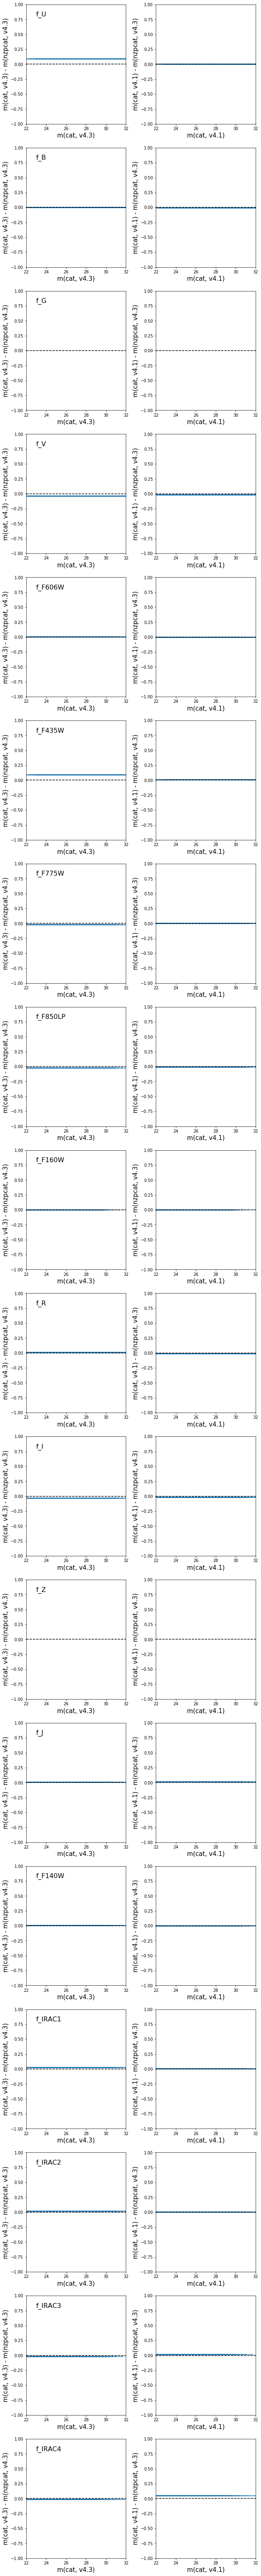

In [12]:
bands = array(['f_U', 'f_B','f_G', 'f_V', 'f_F606W', 'f_F435W', 'f_F775W', 'f_F850LP', 'f_F160W', 'f_R', 'f_I', 'f_Z', 'f_J', 'f_F140W', 'f_IRAC1', 'f_IRAC2', 'f_IRAC3', 'f_IRAC4'])




fig, axes = plt.subplots(len(bands), 2, figsize = (10,5*len(bands)))



for b, band in enumerate(bands):

    f_z = 25.0 - 2.5*log10(gdn_cat[:,np.where(colnames == band)[0]])
    f_z_v41 =  25.0 -  2.5*log10(gdn_cat_v41[:,np.where(colnames2 == band)[0]])
    f_z_npz =  25.0 -  2.5*log10(gdn_nzpcat[:,np.where(colnames == band)[0]])
    
    axes[b][0].plot(f_z, f_z_npz - f_z, '.', markersize = 1)
    axes[b][1].plot(f_z_v41, f_z_v41 - f_z, '.', markersize = 1)
    
    
    fs = 15
    axes[b][0].annotate('%s'%band, (0.1, 0.9), xycoords = 'axes fraction', fontsize = 16)
    axes[b][0].set_ylabel('m(cat, v4.3) - m(nzpcat, v4.3)', fontsize = fs)
    axes[b][1].set_ylabel('m(cat, v4.1) - m(nzpcat, v4.3)', fontsize = fs)
    axes[b][0].set_xlabel('m(cat, v4.3)', fontsize = fs)
    axes[b][1].set_xlabel('m(cat, v4.1)', fontsize = fs)
    
    good = where(isfinite(f_z_v41) & isfinite(f_z))
    print (band, nanmean(f_z_v41[good] - f_z[good]))
    print (band, nanmean(f_z_npz[good] - f_z[good]))
    
    
for ax in axes.ravel():
    ax.set_xlim(22, 32)
    ax.set_ylim(-1, 1)
    ax.axhline(y = 0, color = 'black', linestyle = '--')

fig.subplots_adjust(wspace = 0.30, top = 0.98, bottom = 0.02)
fig.savefig('check_photometry.png', dpi = 300)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


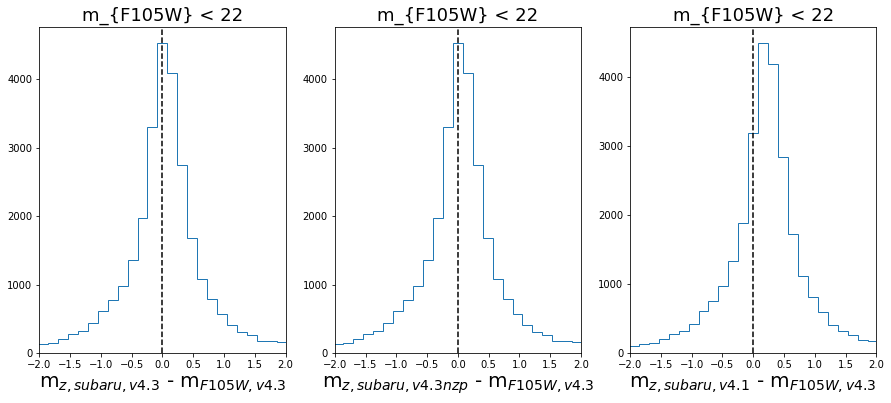

In [105]:
fig, axes = plt.subplots(1,3, figsize = (15,6))



f_f105w = 25 - 2.5*log10(gdn_cat[:, np.where(colnames == 'f_F105W')[0][0]])
f_z =     25 - 2.5*log10(gdn_cat[:, np.where(colnames == 'f_Z')[0][0]])
f_nzp =   25 - 2.5*log10(gdn_nzpcat[:, np.where(colnames == 'f_Z')[0][0]])
f_z_v41 = 25 - 2.5*log10(gdn_cat_v41[:, np.where(colnames == 'f_Z')[0][0]])



#axes[0][0].hist(f_z, f_z_v41, '.')
gd = where(~isnan(f_z) & ~isnan(f_f105w) & ~isnan(f_npz) & isfinite(f_npz) & isfinite(f_z) & isfinite(f_f105w) & (f_f105w > 22))
axes[0].hist(f_z[gd] - f_f105w[gd], histtype = 'step', bins = linspace(-8, 8, 100))
axes[1].hist(f_nzp[gd] - f_f105w[gd], histtype = 'step', bins = linspace(-8, 8, 100))
axes[2].hist(f_z_v41[gd] - f_f105w[gd], histtype = 'step', bins = linspace(-8, 8, 100))

axes[0].set_xlabel('m$_{z,subaru, v4.3}$ - m$_{F105W, v4.3}$', fontsize = 20)
axes[1].set_xlabel('m$_{z,subaru, v4.3nzp}$ - m$_{F105W, v4.3}$', fontsize = 20)
axes[2].set_xlabel('m$_{z,subaru, v4.1}$ - m$_{F105W, v4.3}$', fontsize = 20)

for ax in axes.ravel():
    ax.set_title('m_{F105W} < 22', fontsize = 18)#, (0.6, 0.9), xycoords = 'axes fraction', fontsize = 20)

for ax in axes:
    ax.set_xlim(-2, 2)
    ax.axvline(x = 0.0, color = 'black', linestyle = '--')


fig.savefig('hist_m_differences.png', dpi = 300)
